In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split, Dataset

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

cudnn.bechmark = True
plt.ion()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [4]:
path_last_trained = f"/content/drive/My Drive/Models/last_trained/leukemia.pth"
path_min_loss = f"/content/drive/My Drive/Models/min_loss/leukemia.pth"
path_max_acc = f"/content/drive/My Drive/Models/max_acc/leukemia.pth"

In [5]:
num_epochs = 35
batch_size = 64
lr_rate = 1e-4
load_model = True

In [6]:
class NumpyDataset(Dataset):
    def __init__(self, x_file, y_file, transform=None):
        self.x_data = np.load(x_file)
        self.y_data = np.load(y_file)
        self.transform = transform
        self.label_encoder = LabelEncoder()
        self.y_data = self.label_encoder.fit_transform(self.y_data)


    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]

        if self.transform:
            x = self.transform(x)
            # y = torch.Tensor(y)

        return x, y

In [7]:
transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize((224,224)),
                                transforms.RandomRotation(15),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [8]:
x_file = '/content/drive/MyDrive/Datasets/Leukemia/X_Leukemia.npy'
y_file = '/content/drive/MyDrive/Datasets/Leukemia/Y_Leukemia.npy'

In [9]:
dataset = NumpyDataset(x_file=x_file, y_file=y_file, transform=transform)

In [10]:
dataset[0]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [11]:
train_ratio = 0.7
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [12]:
val_ratio = 0.7
val_size = int(val_ratio * len(val_ds))
test_size = len(val_ds) - val_size
val_ds, test_ds = random_split(val_ds, [val_size, test_size])

In [13]:
len(train_ds), len(val_ds), len(test_ds)

(7462, 2239, 960)

In [14]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=2)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

In [15]:
classes = ["Affected", "Normal"]

In [16]:
samp = iter(train_dl)
images, labels = next(samp)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [17]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

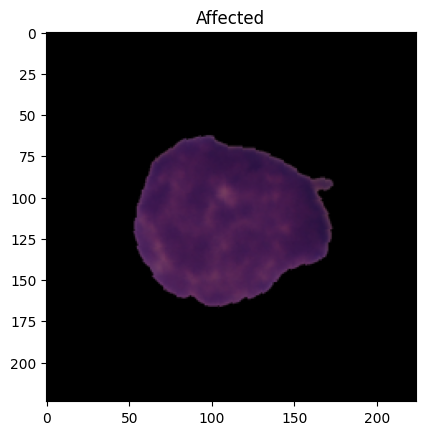

In [18]:
idx = 6
imshow(images[idx], classes[int(labels[idx])])

In [19]:
def save_checkpoint(state, filename=path_last_trained):
  print("===> Saving checkpoint")
  torch.save(state, filename)

In [20]:
def load_checkpoint(checkpoint):
  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  print("===> Checkpoint Loaded.")
  return checkpoint['epoch'], checkpoint['loss'], checkpoint['accuracy']

In [21]:
!pip install transformers
from transformers import ViTModel, ViTConfig

class ViT(nn.Module):

  def __init__(self, config=ViTConfig(), hidden_layers = 256, num_labels=2,
               model_checkpoint='google/vit-base-patch16-224-in21k'):

        super(ViT, self).__init__()

        self.vit = ViTModel.from_pretrained(model_checkpoint, add_pooling_layer=False)
        self.gru = nn.GRU(151296, hidden_layers, batch_first=True)
        self.classifier = (
            nn.Linear(hidden_layers, num_labels)
        )

  def forward(self, x):

    x = self.vit(x)['last_hidden_state']
    x = torch.flatten(x, start_dim=1)
    # x = x.view(x.size(0), x.size(1), -1)
    output, x = self.gru(x)
    # Use the embedding of [CLS] token
    output = self.classifier(output)

    return output

In [22]:
model = ViT().to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# model = models.resnet18().to(device)

In [23]:
optimizer = optim.AdamW(model.parameters(), lr=lr_rate)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [24]:
import math
if load_model:
  prev_epoch, prev_loss, prev_acc = load_checkpoint(torch.load(path_last_trained))
else:
  prev_epoch = 0
  prev_loss = math.inf
  prev_acc = -math.inf

===> Checkpoint Loaded.


In [26]:
import time
model.train()

history = {'train_loss':[], "val_loss":[], 'test_loss':[], 'train_acc':[], "val_acc":[], 'test_acc':[]}
total_time = 0

for epoch in range(num_epochs):
  start_time = time.time()
  losses = 0.0
  accs = 0.0
  for images, targets in train_dl:
    images, targets = images.to(device), targets.to(device)

    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()

    losses += loss.item()
    predict = output.argmax(dim=1).squeeze()
    accs += (predict==targets).sum().item() / len(targets)

  new_loss = losses/len(train_dl)
  history['train_loss'].append(losses/len(train_dl))
  history["train_acc"].append(accs/len(train_dl))

  losses = 0.0
  accs = 0.0
  with torch.no_grad():
    for images, targets in val_dl:
      images, targets = images.to(device), targets.to(device)

      output = model(images)
      loss = criterion(output, targets)

      losses += loss.item()
      predict = output.argmax(dim=1).squeeze()
      accs += (predict==targets).sum().item() / len(targets)

    new_acc = 100*accs/len(val_dl)
    history['val_loss'].append(losses/len(val_dl))
    history["val_acc"].append(accs/len(val_dl))

  losses = 0.0
  accs = 0.0
  y_pred = []
  y_true = []
  with torch.no_grad():
    for images, targets in test_dl:
      images, targets = images.to(device), targets.to(device)

      output = model(images)
      loss = criterion(output, targets)

      losses += loss.item()
      predict = output.argmax(dim=1).squeeze()
      y_pred.extend(predict.data.cpu().numpy())
      accs += (predict==targets).sum().item() / len(targets)
      y_true.extend(targets.data.cpu().numpy())

    history['test_loss'].append(losses/len(test_dl))
    history["test_acc"].append(accs/len(test_dl))

  checkpoint = {'epoch': epoch, 'loss': new_loss, 'accuracy': new_acc, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
  save_checkpoint(checkpoint, path_last_trained)
  if new_loss < prev_loss:
    save_checkpoint(checkpoint, path_min_loss)
    prev_loss = new_loss
  if new_acc > prev_acc:
    save_checkpoint(checkpoint, path_max_acc)
    prev_acc = new_acc

  end_time = time.time()
  total_time += end_time - start_time
  print(f"Epoch {epoch+1}/{num_epochs} - {(end_time-start_time):.2f}s ====> Train Loss: {history['train_loss'][-1]:.4f} Val Loss: {history['val_loss'][-1]:.4f} Test Loss: {history['test_loss'][-1]:.4f} Train Accuracy: {history['train_acc'][-1]*100:.2f} Val Accuracy: {history['val_acc'][-1]*100:.2f} Test Accuracy: {history['test_acc'][-1]*100:.2f}")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


===> Saving checkpoint
===> Saving checkpoint
===> Saving checkpoint
Epoch 1/35 - 379.15s ====> Train Loss: 0.0931 Val Loss: 0.0831 Test Loss: 0.0766 Train Accuracy: 96.79 Val Accuracy: 97.19 Test Accuracy: 97.71


KeyboardInterrupt: 

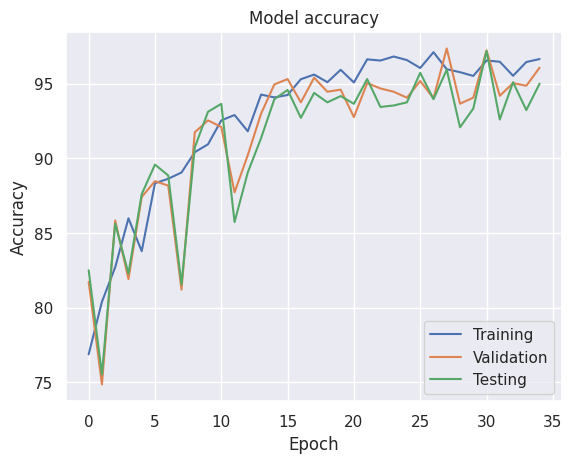

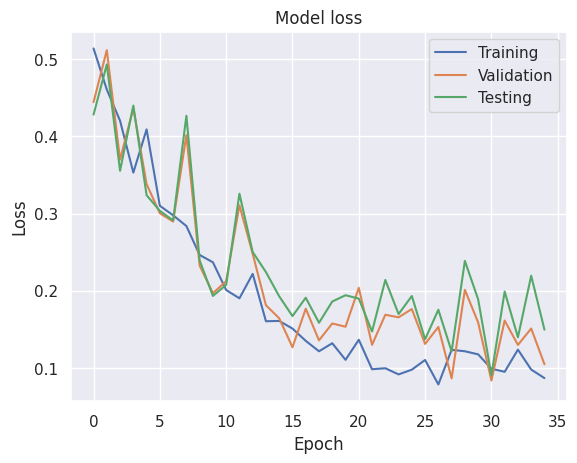

In [ ]:
import seaborn as sns
sns.set_theme()
epoch = list(range(len(history["train_acc"])))
# summarize history for accuracy
plt.plot(epoch, history["train_acc"])
plt.plot(epoch, history["val_acc"])
plt.plot(epoch, history["test_acc"])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation', 'Testing'], loc='lower right')
plt.savefig(f'accuracy.jpg', dpi=500)
plt.show()

# summarize history for loss
plt.plot(epoch, history["train_loss"])
plt.plot(epoch, history["val_loss"])
plt.plot(epoch, history["test_loss"])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation', 'Testing'], loc='upper right')
plt.savefig(f'loss.jpg', dpi=500)
plt.show()


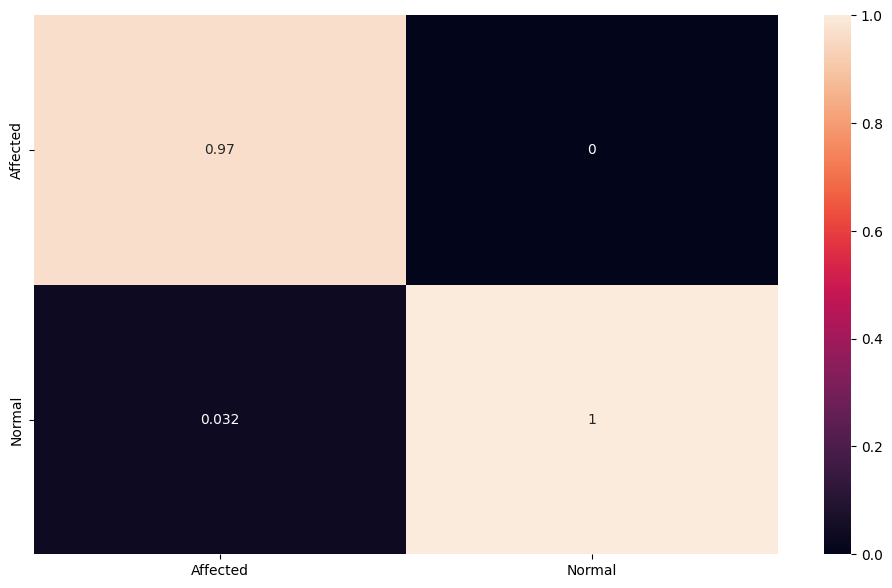

In [27]:
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=0), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.savefig(f'confusionMatrix.jpg', dpi=500)

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       659
           1       1.00      0.93      0.96       301

    accuracy                           0.98       960
   macro avg       0.98      0.96      0.97       960
weighted avg       0.98      0.98      0.98       960



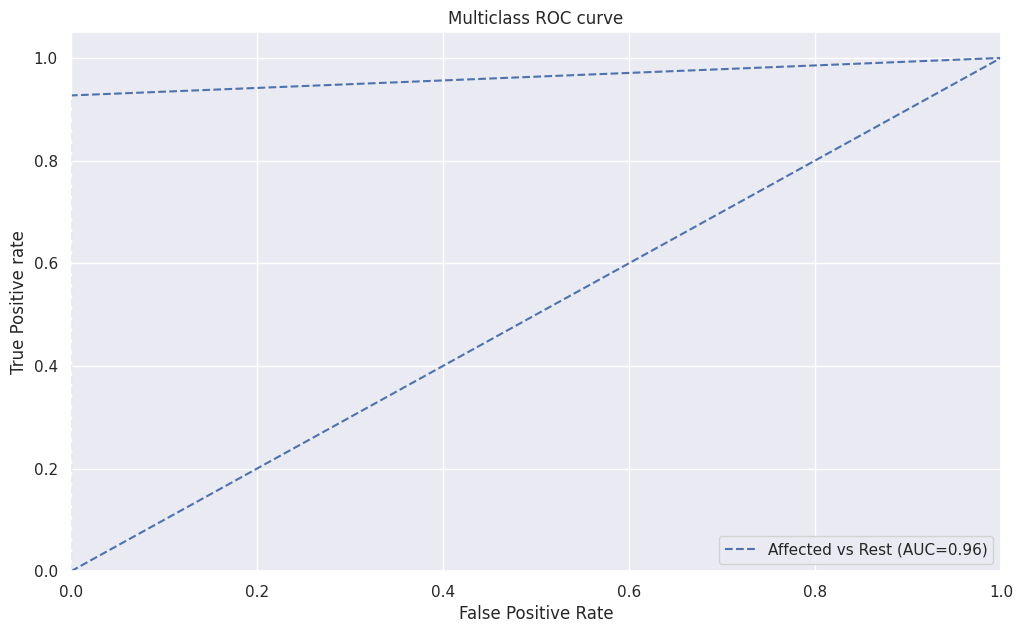

In [29]:
from sklearn.metrics import roc_curve, auc


from sklearn.preprocessing import label_binarize
y_true = label_binarize(y_true, classes=[0,1])
y_pred = label_binarize(y_pred, classes=[0,1])
y_true.shape, y_pred.shape


# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

n_class = len(classes)-1
sns.set_theme()
plt.figure(figsize = (12,7))


for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_true[:,i], y_pred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # plotting
    plt.plot(fpr[i], tpr[i], linestyle='--',
             label='%s vs Rest (AUC=%0.2f)'%(classes[i],roc_auc[i]))
plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.savefig(f'roc_curve_smids.jpg', dpi=500)
plt.show()